Importing all the libraries needed


In [14]:
#Importing all the libraries needed
import pandas as pd
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


Load the datasets

In [3]:
# Load data
transactions = pd.read_csv('transactions.csv')
demographics = pd.read_csv('customer_demographics.csv')
address = pd.read_csv('customer_address.csv')

Merging the datasets

In [4]:
#merging datasets
merged_data = pd.merge(transactions, address, on="customer_id", how="left")
merged_data = pd.merge(merged_data, demographics, on="customer_id", how="left")

print(merged_data.head())


   transaction_id  product_id  customer_id transaction_date online_order  \
0               1           2         2950        2/25/2017        False   
1               2           3         3120        5/21/2017         True   
2               3          37          402       10/16/2017        False   
3               4          88         3135        8/31/2017        False   
4               5          78          787        10/1/2017         True   

  order_status           brand product_line product_class product_size  ...  \
0     Approved           Solex     Standard        medium       medium  ...   
1     Approved   Trek Bicycles     Standard        medium        large  ...   
2     Approved      OHM Cycles     Standard           low       medium  ...   
3     Approved  Norco Bicycles     Standard        medium       medium  ...   
4     Approved  Giant Bicycles     Standard        medium        large  ...   

   gender past_3_years_bike_related_purchases         DOB  \
0    Ma

Data Cleaning

In [5]:
#Dealing with missing values
merged_data.isnull().sum()

transaction_id           0
product_id               0
customer_id              0
transaction_date         0
online_order           360
                      ... 
wealth_segment           3
deceased_indicator       3
default               1454
owns_car                 3
tenure                 449
Length: 280, dtype: int64

In [6]:
#Dropping columns
merged_data.drop(columns=["online_order", "wealth_segment", "deceased_indicator", "default", "owns_car", "tenure"], inplace=True)

In [7]:
merged_data["transaction_date"].isnull().sum()

0

In [8]:
# Convert columns to appropriate formats
merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])


Exploratory Data Analysis (EDA)

In [9]:
merged_data.shape

(20000, 274)

Feature Engineering

Calculate RFM metrics:
Recency: Days since the last purchase.
Frequency: Number of purchases.
Monetary: Total amount spent.

In [12]:
# Calculate RFM metrics

# Reference date for recency
reference_date = merged_data['transaction_date'].max() + pd.Timedelta(days=1)

rfm = merged_data.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'list_price': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())


   customer_id  Recency  Frequency  Monetary
0            1        8         11   9084.45
1            2      129          3   4149.07
2            3      103          8   9888.23
3            4      196          2   1047.72
4            5       17          6   5903.20


Data Preprocessing for Clustering

In [15]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

print(rfm_scaled[:5])  # Check the scaled data

[[-0.93137335  2.26867788  0.927136  ]
 [ 1.16281857 -1.1713831  -0.74094992]
 [ 0.71282692  0.97865501  1.19880182]
 [ 2.32241245 -1.60139073 -1.78916065]
 [-0.77560701  0.11863977 -0.14807976]]


Apply Clustering

In [16]:
# Find the optimal number of clusters (Elbow Method)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


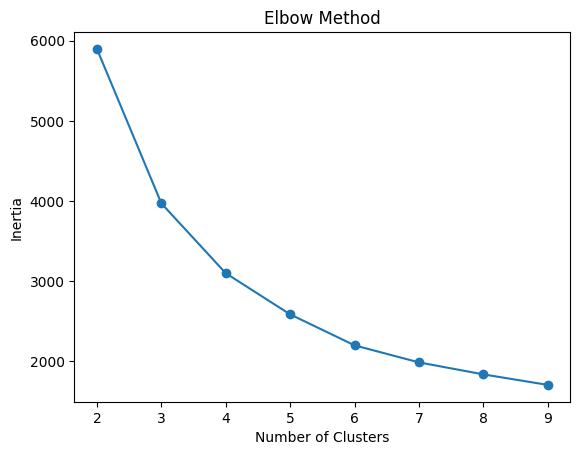

In [17]:

# Plot the Elbow Curve
import matplotlib.pyplot as plt

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [18]:

# Apply K-Means with optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())


   customer_id  Recency  Frequency  Monetary  Cluster
0            1        8         11   9084.45        1
1            2      129          3   4149.07        3
2            3      103          8   9888.23        1
3            4      196          2   1047.72        3
4            5       17          6   5903.20        2


Analyze clusters

In [ ]:
# Analyze cluster characteristics
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)


Visualize Clusters

Use PCA to reduce dimensions for visualization

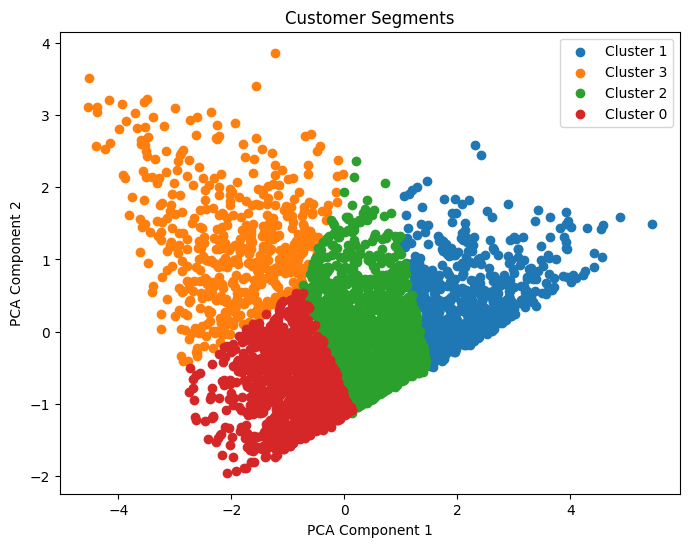

In [19]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in rfm['Cluster'].unique():
    plt.scatter(rfm_pca[rfm['Cluster'] == cluster, 0],
                rfm_pca[rfm['Cluster'] == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments')
plt.legend()
plt.show()


Deployment 

Saving the result for business use

In [20]:
# Save the results
rfm.to_csv("customer_segments.csv", index=False)


Check the Cluster Summary

Load the saved file and analyze the summary statistics of the clusters.

Key Metrics:
Recency (mean): Lower values indicate more recent customers.
Frequency (mean): Higher values indicate more frequent customers.
Monetary (mean): Higher values indicate higher spending.
Cluster Size: Number of customers in each cluster.

In [21]:
# Load the results
rfm_clusters = pd.read_csv("customer_segments.csv")

# Summarize clusters
cluster_summary = rfm_clusters.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'  # Size of each cluster
}).rename(columns={'customer_id': 'Cluster Size'})

print(cluster_summary)


            Recency  Frequency      Monetary  Cluster Size
Cluster                                                   
0         43.517143   3.864762   3939.885905          1050
1         32.995122   9.229268  10887.245463           615
2         48.406437   6.398204   7071.264424          1336
3        173.064909   3.484787   3806.984888           493


Interpret Each Cluster
Based on the summary, assign meaningful labels to the clusters. For example:

Cluster with Low Recency, High Frequency, High Monetary:

Label: Loyal High Spenders
Action: Offer exclusive rewards or VIP services.

Cluster with High Recency, Low Frequency, Low Monetary:

Label: Lost or Inactive Customers
Action: Run win-back campaigns or special promotions.

Cluster with Medium Recency, High Frequency, Moderate Monetary:

Label: Regular Buyers
Action: Encourage higher spending with cross-sell or upsell strategies.

Cluster with Low Frequency, High Monetary:

Label: Occasional Big Spenders
Action: Keep engaged with high-value offers or personalized attention.

Visualize the Results
Create visualizations to understand the distribution of each cluster better.

Bar Plot of Cluster Averages:

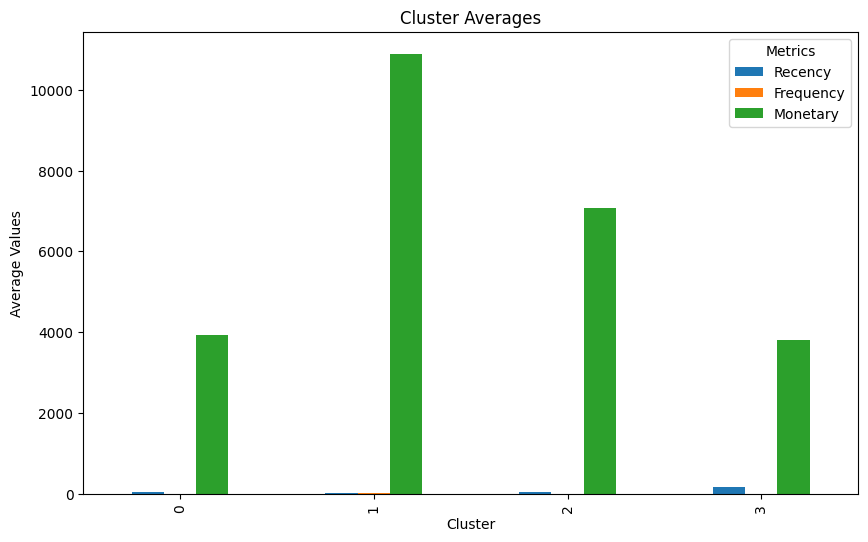

In [22]:
import matplotlib.pyplot as plt

# Plot cluster summary
cluster_summary[['Recency', 'Frequency', 'Monetary']].plot(kind='bar', figsize=(10, 6))
plt.title("Cluster Averages")
plt.xlabel("Cluster")
plt.ylabel("Average Values")
plt.legend(title="Metrics")
plt.show()


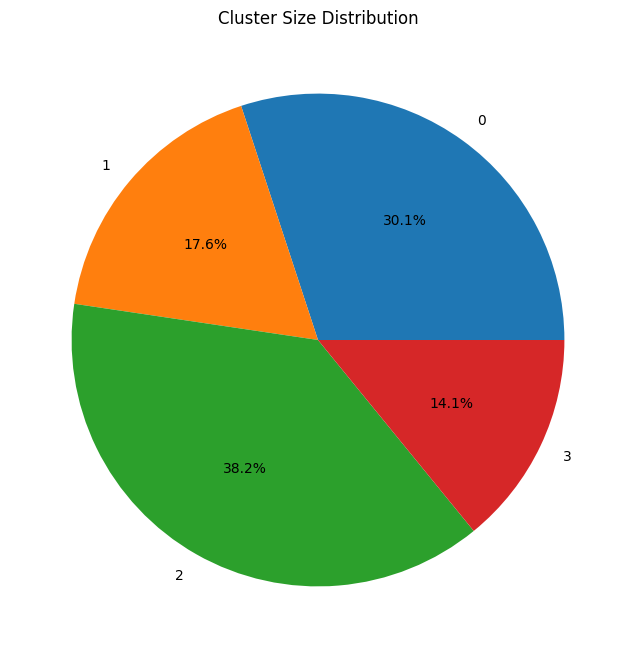

In [23]:
# Plot cluster sizes
cluster_summary['Cluster Size'].plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title("Cluster Size Distribution")
plt.ylabel("")  # Remove y-axis label for cleaner look
plt.show()


Develop Actionable Strategies

Based on the interpretation:

High Recency, High Frequency, High Monetary: These are loyal and active customers. Focus on retention strategies like loyalty programs.
High Recency, Low Frequency, Low Monetary: These are recent but low-engagement customers. Experiment with onboarding strategies or first-time discounts.
Low Recency, Low Frequency, Low Monetary: These are inactive customers. Consider targeted reactivation campaigns.

Document Your Insights
Create a summary report that includes:

Cluster profiles (e.g., "Cluster 1: Loyal Customers").
Size and importance of each cluster.
Suggested actions for each segment.